<a href="https://colab.research.google.com/github/AleksandraPashkova/data_science_sf/blob/master/Homework_04_ML_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML-7. Прогнозирование биологического ответа.


Необходимо предсказать биологический ответ молекул по их химической информации.

*Первый столбец (Activity) содержит экспериментальные данные, описывающие фактический биологический ответ: [0, 1]; остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.*

Предварительная обработка не требуется, данные закодированы и нормализованы.

В качестве метрики использовать **F1-score.**

Необходимо обучить две модели: **логистическую регрессию и случайный лес**. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (**GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna)**, максимальное количество итераций не должно превышать 50.


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Загрузка и предобработка данных

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials
import optuna
from scipy.stats import uniform

In [39]:
data=pd.read_csv('/content/drive/MyDrive/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [40]:
data.shape

(3751, 1777)

Данные предварительно закодированы и нормализованы - предобработка не требуется.

Посмотрим на сбалансированность классов

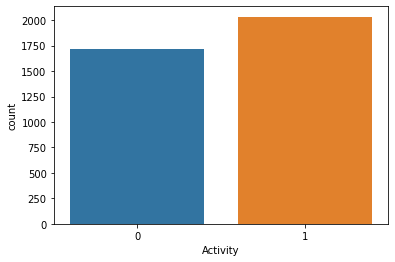

In [41]:
sns.countplot(data=data, x='Activity');

Выборку можно считать сбалансированной, тем не менее применим взвешивание классов при построении моделей. Также учтем этот небольшой дисбаланс при разбиении на тренировочную и тестовую выборки.

Создаем матрицу наблюдений Х и вектор правильных ответов у. Разделяем набор данных на тренировочную и тестовую выборки

In [42]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [43]:
X, y = data.drop(columns='Activity'), data['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
    stratify=y, random_state=RANDOM_STATE)

# **2. Логистическая регрессия**



## **2.1 Базовая модель**

In [44]:
# Логистическая регрессия

logregr = LogisticRegression(class_weight='balanced', n_jobs=-1,
                             random_state=RANDOM_STATE, max_iter=50)
logregr.fit(X_train, y_train)
y_train_pred = logregr.predict(X_train)
y_test_pred = logregr.predict(X_test)

In [45]:
print(f'F1 на тренировочной выборке: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

F1 на тренировочной выборке: 0.8815572418343781
F1 на тестовой выборке: 0.7741935483870969


## **2.2 Оптимизация гиперпараметров GridSearchCV**

In [46]:
# Сетка гиперпараметров
param_grid = [
    
    {'solver': ['saga'],
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.05, 0.1, 0.5, 1.]},
                 
    {'solver': ['lbfgs'],
    'penalty': ['l2'],
    'C': [0.01, 0.05, 0.1, 0.5, 1.]},
    
    {'solver': ['saga'],
    'penalty': ['none']},
]

# Поиск по сетке параметров с кросс-валидацией (5 фолдов)
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', 
        random_state=RANDOM_STATE, max_iter=50
    ), 
    param_grid=param_grid, 
    scoring = 'f1',
    cv=5, 
    n_jobs = -1
)  
grid_search_lr.fit(X_train, y_train) 
y_train_pred = grid_search_lr.predict(X_train)
y_test_pred = grid_search_lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [47]:
print(f'F1 на кросс-валидации: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')
print(f'Наилучшие значения гиперпараметров: {grid_search_lr.best_params_}')

F1 на кросс-валидации: 0.8414514547237659
F1 на тестовой выборке: 0.7782101167315175
Наилучшие значения гиперпараметров: {'C': 0.05, 'penalty': 'l2', 'solver': 'lbfgs'}


## **2.3 Оптимизация гиперпараметров RandomizedSearchCV**

In [48]:
# Пространство параметров
param_distr = [
    
    {'solver': ['saga'],
    'penalty': ['l1', 'l2'],
    'C': uniform(loc=0.01, scale=1)},
                 
    {'solver': ['lbfgs'],
    'penalty': ['l2'],
    'C': uniform(loc=0.01, scale=1)},
    
    {'solver': ['saga'],
    'penalty': ['none']},
]

# Случайный поиск по распределению параметров с кросс-валидацией (5 фолдов)
random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(class_weight='balanced', 
        random_state=RANDOM_STATE, max_iter=50
    ), 
    param_distributions=param_distr, 
    scoring = 'f1',
    cv=5,
    n_iter=20,  # 20 случайных наборов параметров
    n_jobs = -1
)  
random_search_lr.fit(X_train, y_train) 
y_train_pred = random_search_lr.predict(X_train)
y_test_pred = random_search_lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [49]:
print(f'F1 на кросс-валидации: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')
print(f'Наилучшие значения гиперпараметров: {random_search_lr.best_params_}')

F1 на кросс-валидации: 0.8466057441253264
F1 на тестовой выборке: 0.7793974732750243
Наилучшие значения гиперпараметров: {'C': 0.06641157902710025, 'penalty': 'l2', 'solver': 'lbfgs'}


## **2.4 Оптимизация гиперпараметров Hyperopt**

In [50]:
# Пространство параметров
space = hp.choice('parameter_combinations', [
        {'solver': 'saga',
         'penalty': hp.choice('penalty', ['l1', 'l2']),
         'C': hp.uniform('C_saga', 0.01, 1)
        },
        
        {'solver': 'lbfgs',
        'penalty': 'l2',
        'C': hp.uniform('C_lbfgs', 0.01, 1)
        }
        ]
)


# Целевая функция
def obj_func(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    params = {'solver': params['solver'], 
              'penalty': params['penalty'], 
              'C': params['C']
             }
      
    model = LogisticRegression(**params, class_weight='balanced', 
        random_state=random_state, max_iter=50
    )
      
    # Обучаем модель с помощью кросс-валидации
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()

    return -score 


trials = Trials()
best=fmin(obj_func, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          rstate=np.random.RandomState(RANDOM_STATE)
          #rstate=np.random.default_rng(RANDOM_STATE)
         )

100%|██████████| 20/20 [03:29<00:00, 10.46s/it, best loss: -0.7858802414712622]


In [51]:
print(f'Наилучшие значения гиперпараметров: {best}')

Наилучшие значения гиперпараметров: {'C_saga': 0.023051205281475296, 'parameter_combinations': 0, 'penalty': 1}


In [52]:
# Расчет метрики для лучших найденных гиперпараметров 

best_params = {'solver': 'saga',
          'penalty': 'l2', 
          'C': 0.10567819922023905
}

# Модель с лучшими параметрами
hyperopt_lr = LogisticRegression(**best_params, class_weight='balanced',
                                   random_state=RANDOM_STATE, max_iter=50
)
hyperopt_lr.fit(X_train, y_train)
y_train_pred = hyperopt_lr.predict(X_train)
y_test_pred = hyperopt_lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [53]:
best_score = (np.array(list(x['result']['loss'] 
                            for x in trials.trials)) * (-1)).max()
print(f'F1 на кросс-валидации: {best_score}')
print(f'F1 на тренировочной выборке: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

F1 на кросс-валидации: 0.7858802414712622
F1 на тренировочной выборке: 0.8528449967298888
F1 на тестовой выборке: 0.78125


## **2.5 Оптимизация гиперпараметров Optuna**

In [54]:
# Целевая функция
def obj_func(trial):
    # пространство гиперпараметров
    solver = trial.suggest_categorical('solver', ['saga', 'lbfgs'])
    if solver == 'saga':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    else:
        penalty = 'l2'
    C = trial.suggest_uniform('C', 0.01, 1)
    
    model = LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        class_weight='balanced', 
        random_state=RANDOM_STATE, 
        max_iter=50
    )    
    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
study_lr = optuna.create_study(
    sampler=sampler, study_name='LogisticRegression', direction='maximize')
study_lr.optimize(obj_func, n_trials=20)


# Модель с лучшими параметрами
optuna_lr = LogisticRegression(
    **study_lr.best_params, class_weight='balanced', n_jobs=-1,
    random_state=RANDOM_STATE, max_iter=50
)
optuna_lr.fit(X_train, y_train)
y_train_pred = optuna_lr.predict(X_train)
y_test_pred = optuna_lr.predict(X_test)

[I 2022-08-29 09:56:06,203] A new study created in memory with name: LogisticRegression
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
[I 2022-08-29 09:56:08,174] Trial 0 finished with value: 0.7720689829369425 and parameters: {'solver': 'lbfgs', 'C': 0.7346740023932911}. Best is trial 0 with value: 0.7720689829369425.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
[I 2022-08-29 09:56:27,267] Trial 1 finished with value: 0.7850646488868974 and parameters: {'solver': 'saga',

In [55]:
print(f'Наилучшие значения гиперпараметров: {study_lr.best_params}')
print(f'F1 на кросс-валидации: {study_lr.best_value}')
print(f'F1 на тренировочной выборке: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'C': 0.03037864935284442}
F1 на кросс-валидации: 0.788178619142245
F1 на тренировочной выборке: 0.8324077098987259
F1 на тестовой выборке: 0.7738791423001949


# **3. Случайный лес**


## **3.1 Базовая модель**

In [56]:
rforest = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                 random_state=RANDOM_STATE)
rforest.fit(X_train, y_train)
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)
print(f'F1 на тренировочной выборке: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

F1 на тренировочной выборке: 1.0
F1 на тестовой выборке: 0.7961538461538461


## **3.2 Оптимизация гиперпараметров GridSearchCV**

In [57]:
# Сетка параметров
param_grid = [
    
    {'n_estimators': [100, 200, 300],
     'criterion': ['gini', 'entropy'],
     'max_depth': [5, 10, 50],
     'min_samples_leaf': [5, 50]
    }
]

# Поиск по сетке параметров с кросс-валидацией (5 фолдов)
grid_search_rf = GridSearchCV(
    estimator = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                 random_state=RANDOM_STATE), 
    param_grid=param_grid, 
    scoring = 'f1',
    cv=5, 
    n_jobs = -1
)  
grid_search_rf.fit(X_train, y_train) 
y_train_pred = grid_search_rf.predict(X_train)
y_test_pred = grid_search_rf.predict(X_test)
print(f'F1 на кросс-валидации: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')
print(f'Наилучшие значения гиперпараметров: {grid_search_rf.best_params_}')

F1 на кросс-валидации: 0.9532587228439764
F1 на тестовой выборке: 0.7925270403146509
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 300}


## **3.3 Оптимизация гиперпараметров RandomizedSearchCV**

In [58]:
# Распределение параметров (в виде неслучайной сетки)
param_distr = [
    
    {'n_estimators': list(range(100, 500, 100)),
     'criterion': ['gini', 'entropy'],
     'max_depth': list(range(1, 100, 5)),
     'min_samples_leaf': list(range(5, 100, 5))
    }
]

# Случайный поиск по распределению параметров с кросс-валидацией (5 фолдов)
random_search_rf = RandomizedSearchCV(
    estimator = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                 random_state=RANDOM_STATE),
    param_distributions=param_distr, 
    scoring = 'f1',
    cv=5,
    n_iter=20, # 20 случайных наборов параметров
    n_jobs = -1
)  
random_search_rf.fit(X_train, y_train) 
y_train_pred = random_search_rf.predict(X_train)
y_test_pred = random_search_rf.predict(X_test)
print(f'F1 на кросс-валидации: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')
print(f'Наилучшие значения гиперпараметров: {random_search_rf.best_params_}')

F1 на кросс-валидации: 0.9501485638824695
F1 на тестовой выборке: 0.7917888563049853
Наилучшие значения гиперпараметров: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 91, 'criterion': 'entropy'}


## **3.4 Оптимизация гиперпараметров Hyperopt**

In [59]:
# Пространство параметров 
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
       'criterion': hp.choice('criterion', ['gini', 'entropy']),
       'max_depth' : hp.quniform('max_depth', 1, 100, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 100, 1)
      }


# Целевая функция
def obj_func(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_STATE):
    params = {'n_estimators': int(params['n_estimators']),
              'criterion': params['criterion'],
              'max_depth': int(params['max_depth']), 
              'min_samples_leaf': int(params['min_samples_leaf'])
             }
  
    model = RandomForestClassifier(**params, class_weight='balanced', 
                                   n_jobs=-1, random_state=random_state)
    
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    
    return -score


trials = Trials()
best=fmin(obj_func, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials, 
          rstate=np.random.RandomState(RANDOM_STATE)
         )
print(f'Наилучшие значения гиперпараметров: {best}')

100%|██████████| 20/20 [02:55<00:00,  8.80s/it, best loss: -0.8220957010855259]
Наилучшие значения гиперпараметров: {'criterion': 0, 'max_depth': 85.0, 'min_samples_leaf': 3.0, 'n_estimators': 311.0}


In [60]:
# Расчет метрики для лучших найденных гиперпараметров 

best_score = (np.array(list(x['result']['loss'] 
                            for x in trials.trials)) * (-1)).max()
print(f'F1 на кросс-валидации: {best_score}')

best_params = {
    'n_estimators': int(best['n_estimators']),
    'criterion': 'gini',
    'max_depth': int(best['max_depth']),
    'min_samples_leaf': int(best['min_samples_leaf'])
}

# Модель с лучшими параметрами
hyperopt_rf = RandomForestClassifier(**best_params, class_weight='balanced',
                                 n_jobs=-1, random_state=RANDOM_STATE)
hyperopt_rf.fit(X_train, y_train)
y_train_pred = hyperopt_rf.predict(X_train)
y_test_pred = hyperopt_rf.predict(X_test)
print(f'F1 на тренировочной выборке: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

F1 на кросс-валидации: 0.8220957010855259
F1 на тренировочной выборке: 0.9747458183010823
F1 на тестовой выборке: 0.7968901846452867


## **3.5 Оптимизация гиперпараметров Optuna**

In [61]:
# Целевая функция
def obj_func(trial):
    # пространство гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 500, 1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 1, 100, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100, 1)
  
    # модель
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced', n_jobs=-1,
        random_state=RANDOM_STATE
    )
  
    # Обучаем модель с помощью кросс-валидации    
    score = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=RANDOM_STATE)
study_rf = optuna.create_study(
    sampler=sampler, study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(obj_func, n_trials=20)


# Модель с лучшими параметрами  
optuna_rf = RandomForestClassifier(
    **study_rf.best_params, class_weight='balanced', n_jobs=-1,
    random_state=RANDOM_STATE
)
optuna_rf.fit(X_train, y_train)
y_train_pred = optuna_rf.predict(X_train)
y_test_pred = optuna_rf.predict(X_test)

[I 2022-08-29 10:08:10,247] A new study created in memory with name: RandomForestClassifier
[I 2022-08-29 10:08:19,446] Trial 0 finished with value: 0.7831966399562867 and parameters: {'n_estimators': 250, 'criterion': 'gini', 'max_depth': 60, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.7831966399562867.
[I 2022-08-29 10:08:23,973] Trial 1 finished with value: 0.731543003621627 and parameters: {'n_estimators': 162, 'criterion': 'entropy', 'max_depth': 61, 'min_samples_leaf': 72}. Best is trial 0 with value: 0.7831966399562867.
[I 2022-08-29 10:08:27,971] Trial 2 finished with value: 0.7723552409530227 and parameters: {'n_estimators': 108, 'criterion': 'gini', 'max_depth': 22, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.7831966399562867.
[I 2022-08-29 10:08:34,153] Trial 3 finished with value: 0.7658886633515352 and parameters: {'n_estimators': 173, 'criterion': 'entropy', 'max_depth': 44, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.7831966399562867.
[I 

In [62]:
print(f'Наилучшие значения гиперпараметров: {study_rf.best_params}')
print(f'F1 на кросс-валидации: {study_rf.best_value}')
print(f'F1 на тренировочной выборке: {f1_score(y_train, y_train_pred)}')
print(f'F1 на тестовой выборке: {f1_score(y_test, y_test_pred)}')

Наилучшие значения гиперпараметров: {'n_estimators': 249, 'criterion': 'gini', 'max_depth': 75, 'min_samples_leaf': 3}
F1 на кросс-валидации: 0.8209361721872475
F1 на тренировочной выборке: 0.9747789059941041
F1 на тестовой выборке: 0.7988338192419825
